In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
os.chdir('../../')

In [3]:
from src.numpy_encode import *
from src.utils.file_processing import process_all, process_file
from src.config import *
from src.music_transformer import *
from src.multitask_transformer import *
from src.utils.stacked_dataloader import StackedDataBunch

In [4]:
from fastai.text import *

## Example notebook explaining how to encode midi to numpy array and train with fastai

Numpy format 

In [5]:
data_path = Path('data')

# Location of your midi files
midi_path = data_path/'midi'
midi_path.mkdir(parents=True, exist_ok=True)

# Location of transformed midi to numpy dataset
numpy_path = data_path/'numpy'
numpy_path.mkdir(parents=True, exist_ok=True)

data_save_name = 'musicitem_data_save.pkl'
s2s_data_save_name = 'multiitem_data_save.pkl'

## 1. Gather midi dataset

Make sure all your midi data is in `musicautobot/data/midi` directory

Here's a pretty good dataset with lots of midi data:  
https://www.reddit.com/r/datasets/comments/3akhxy/the_largest_midi_collection_on_the_internet/

Download the folder and unzip it to `data/midi`

## 3. Create dataset from encoded files

In [ ]:
midi_files = get_files(midi_path, '.mid', recurse=True); len(midi_files)

In [ ]:
processors = [Midi2ItemProcessor()]
data = MusicDataBunch.from_files(midi_files, numpy_path, processors=processors, encode_position=True,)
data.save(data_save_name)

## 3b. Encode sequence 2 sequence files

In [ ]:
processors = [Midi2MultitrackProcessor()]
s2s_data = MusicDataBunch.from_files(midi_files, numpy_path, processors=processors, 
                                     preloader_cls=S2SPreloader, list_cls=S2SItemList)
s2s_data.save(s2s_data_save_name)

## 4. Load Model

In [ ]:
batch_size = 2
bptt = 128

lm_data = load_data(numpy_path, data_save_name, 
                    bs=batch_size, bptt=bptt, encode_position=True,
                    dl_tfms=mask_lm_tfm)

s2s_data = load_data(numpy_path, s2s_data_save_name, 
                     bs=batch_size//2, bptt=bptt,
                     preloader_cls=S2SPreloader, dl_tfms=melody_chord_tfm)

data = StackedDataBunch([lm_data, s2s_data])

In [10]:
config = mlm_config(); config

learn = multitask_model_learner(data, config.copy())

In [11]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,mask_acc,lm_acc,c2m_acc,m2c_acc,time
0,7.570653,9.691721,0.000000,0.207831,0.251969,0.111111,00:05
1,7.407166,8.854544,0.214783,0.215674,0.330709,0.000000,00:05
2,6.956740,8.443754,0.186980,0.274514,0.330709,0.000000,00:05
3,6.920445,8.529146,0.232468,0.207800,0.000000,0.000000,00:05


## 5. Prediction time

In [13]:
midi_files = get_files(data_path, '.mid', recurse=True)
midi_file = midi_files[0]; midi_file

PosixPath('data/midi/examples/Levels - Avicii - Verse.mid')

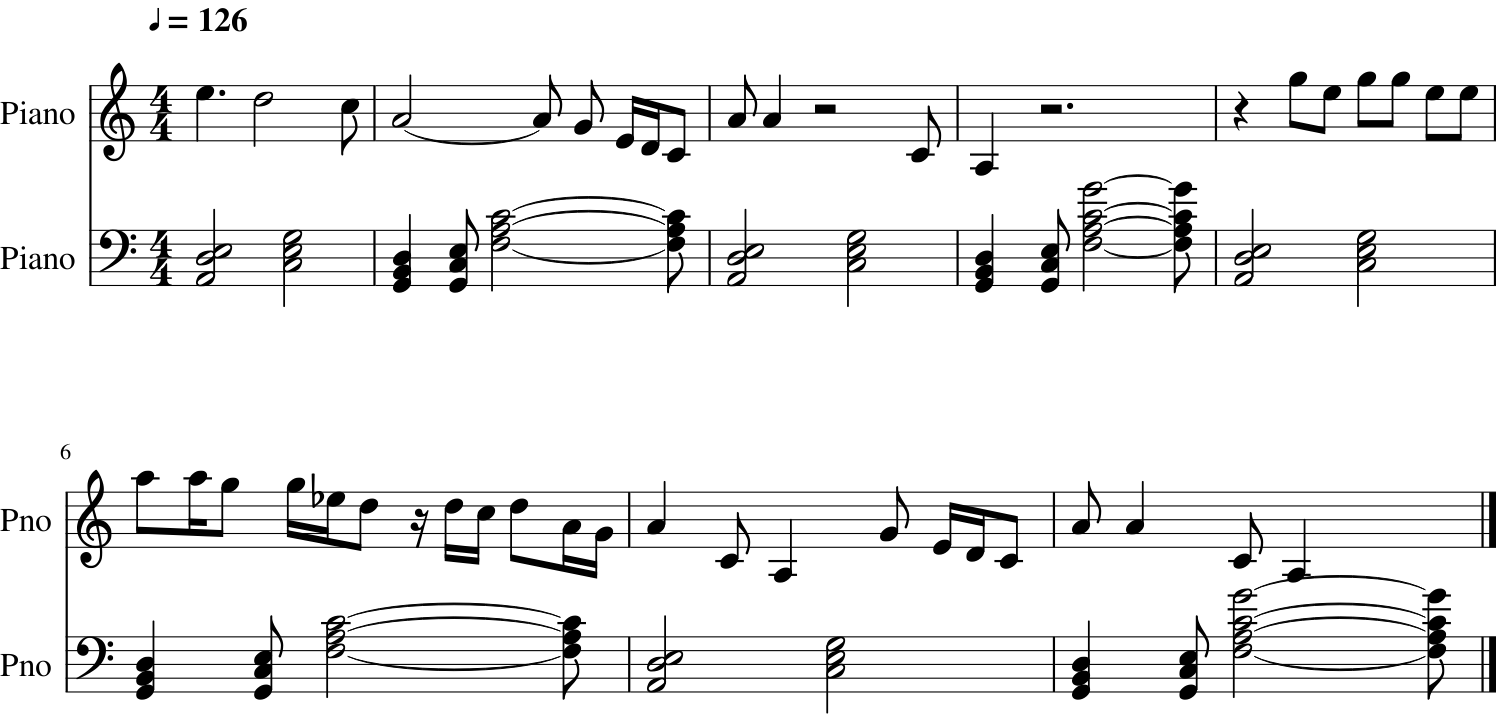

In [14]:
item = MusicItem.from_file(midi_file, data.vocab)
item.show()

Only send a few notes 

Here's what the seed sounds like:

## Predictions

See MultitaskGenerate.ipynb for more in depth example on how to generate

Non midi note detected. Only returning valid portion. Index, seed 34 (233, 2)


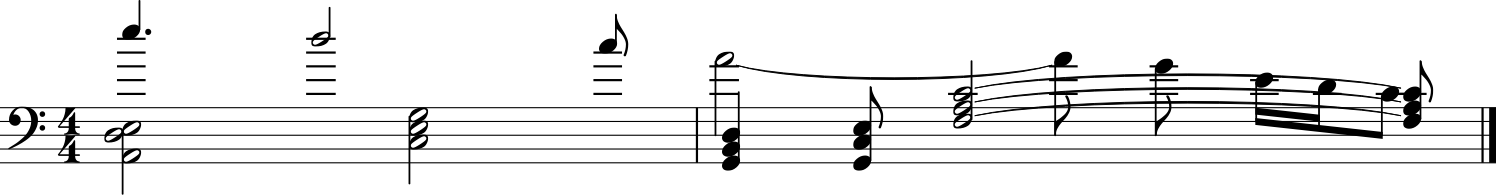

In [15]:
next_word = nw_predict_from_midi(learn, midi_file, seed_len=8); next_word.show()

Predicting BOS/EOS
Non midi note detected. Only returning valid portion. Index, seed 7 (23, 2)


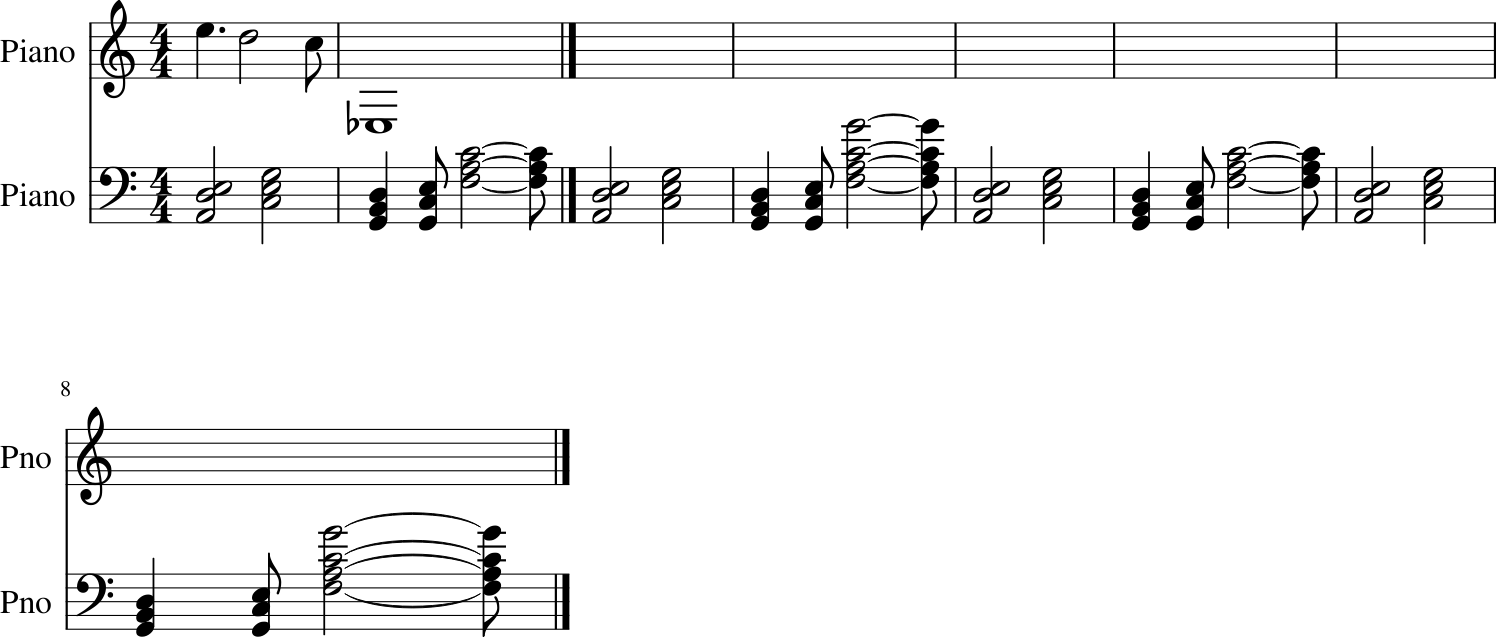

In [16]:
pred_melody = s2s_predict_from_midi(learn, midi_file, seed_len=4, pred_melody=True); pred_melody.show()

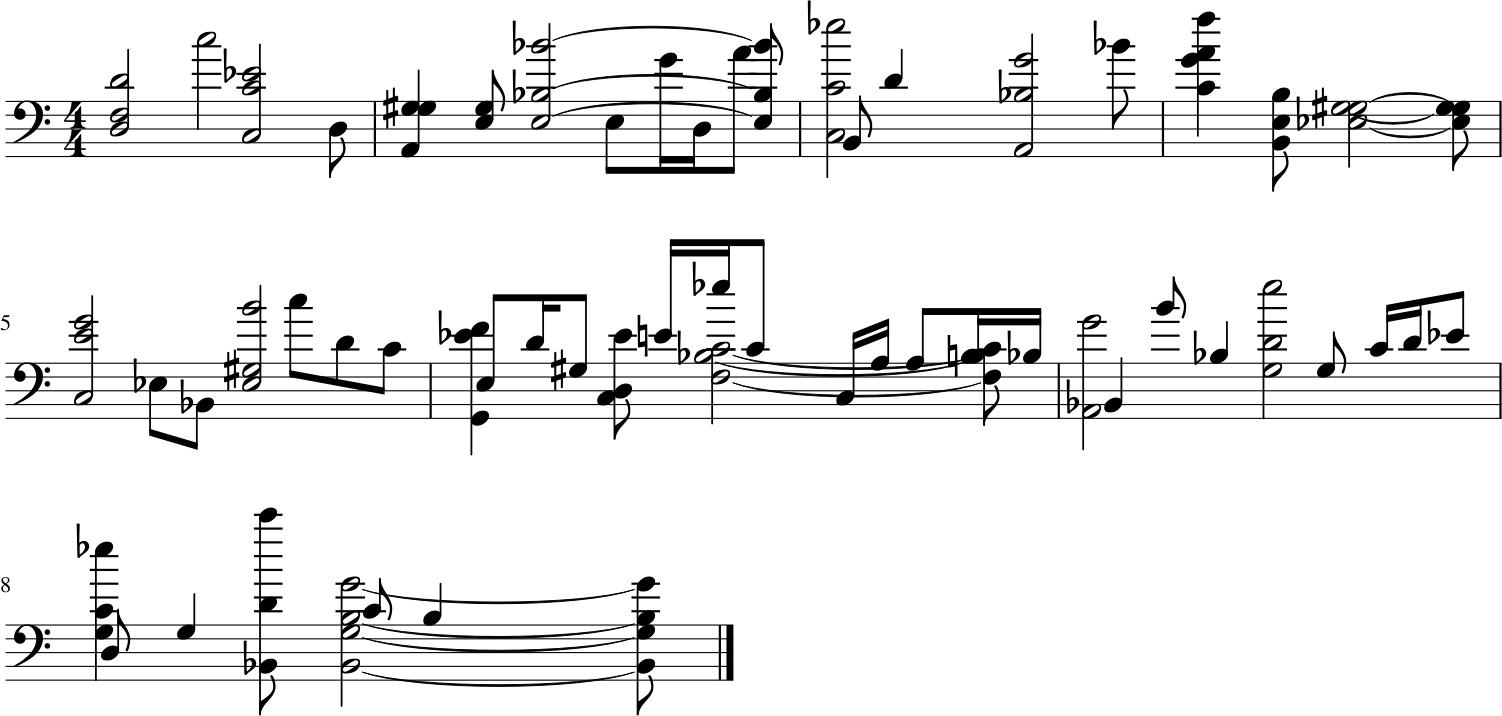

In [17]:
pred_notes = mask_predict_from_midi(learn, midi_file, predict_notes=True); pred_notes.show()